# Item sales demand forecasting

### Summary

<b> Observations: </b> HERE

In [235]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
from statsmodels.tsa.seasonal import seasonal_decompose

In [236]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [237]:
train_df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [238]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
train_df = train_df[train_df['store'] == 1]
train_df = train_df[train_df['item'] == 1]

# <<<<<< create test_df from train_df HERE >>>>>>

train_df['date'] = pd.to_datetime(train_df['date'], format='%Y-%m-%d') # convert date column to datatime object
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


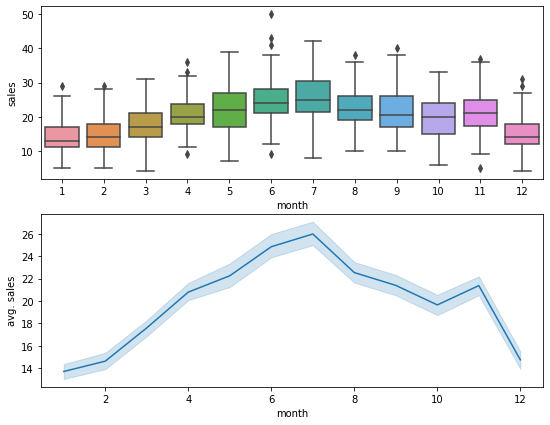

In [221]:
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=train_df, ax=axs[0])
sn.lineplot(x='month', y='sales', data=train_df, ax=axs[1])
_ = axs[1].set(ylabel='avg. sales')

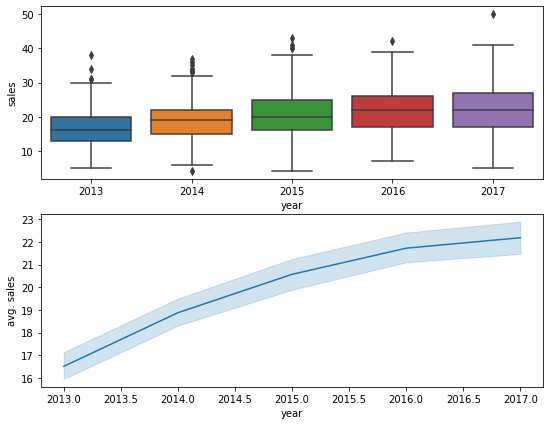

In [222]:
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=train_df, ax=axs[0])
sn.lineplot(x='year', y='sales', data=train_df, ax=axs[1])
_ = axs[1].set(ylabel='avg. sales')

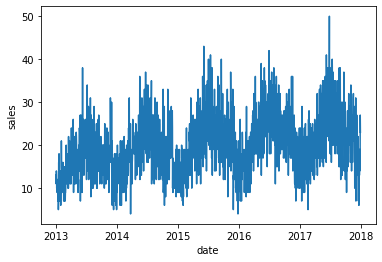

In [223]:
sn.lineplot(x='date', y='sales', data=train_df)

### Baseline Model: Seasonal Naive

In [247]:
test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%d') # converting date to datetime object
dates = (test_df['date'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]') # subtract 1 year from test data
seasonal_naive = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['sales'] 

# make a copy of the test_df and filter store 1 and item 1
sn_test_df = test_df.copy()
sn_test_df = sn_test_df[sn_test_df['store'] == 1]
sn_test_df = sn_test_df[sn_test_df['item'] == 1]


,id,date,store,item,seasonal_naive
0,0,2018-01-01,1,1,NaN
1,1,2018-01-02,1,1,NaN
2,2,2018-01-03,1,1,NaN
3,3,2018-01-04,1,1,NaN
4,4,2018-01-05,1,1,NaN
...,...,...,...,...,...
85,85,2018-03-27,1,1,NaN
86,86,2018-03-28,1,1,NaN
87,87,2018-03-29,1,1,NaN
88,88,2018-03-30,1,1,NaN


### Time Series Decomposition

<b> Observations: </b> HERE

In [225]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,store,item,sales,year,month,day
date,,,,,,
2013-01-01,1,1,13.0,2013,1,1
2013-01-02,1,1,11.0,2013,1,2
2013-01-03,1,1,14.0,2013,1,3
2013-01-04,1,1,13.0,2013,1,4
2013-01-05,1,1,10.0,2013,1,5


<Figure size 432x288 with 0 Axes>

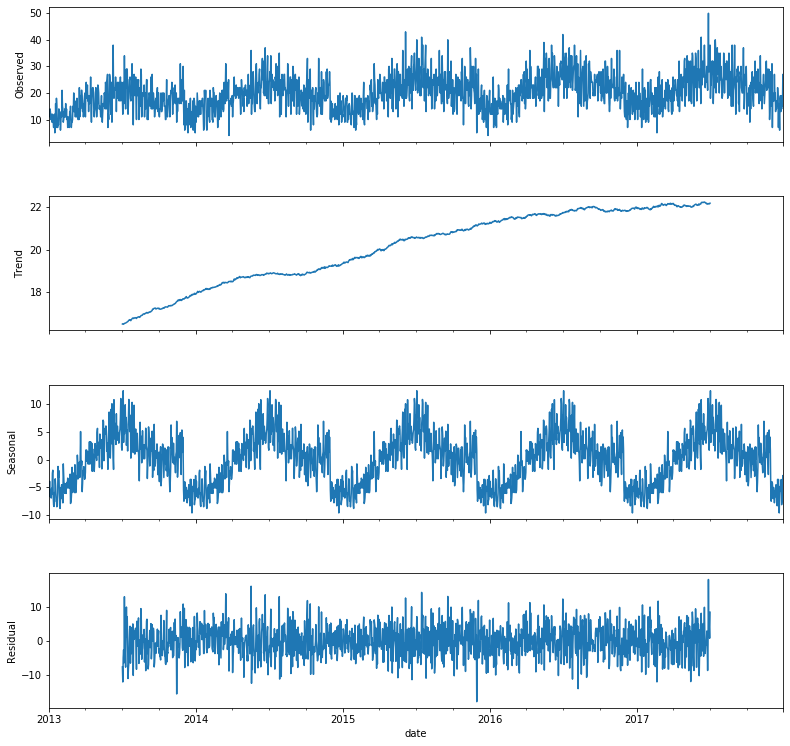

In [226]:
result = seasonal_decompose(ts_decomp_df['sales'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 12)